In [1]:
import light_curve as licu
import lsdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
from dask.distributed import Client

In [2]:
%pip install s3fs light_curve --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# load ztf into lsdb
ztf_dr23 = lsdb.open_catalog('s3://ipac-irsa-ztf/contributed/dr23/lc/hats')

In [4]:
# crossmatch with 10 csv locations
variables_csv = \
"""ra,dec,period
94.95546,-24.73952,0.12095
95.30235,-25.27431,0.12248
94.91626,-24.69648,0.12038
95.12418,-25.04329,0.23554
58.83506,-48.79122,0.56335
94.92264,-25.23185,0.07672
94.72086,-25.05767,0.17559
94.97073,-25.13643,0.12048
59.12997,-48.78522,0.11628
94.72086,-25.05767,0.17554
"""
variables_df = pd.read_csv(StringIO(variables_csv)).reset_index()

In [5]:
result = lsdb.crossmatch(
    variables_df, ztf_dr23, radius_arcsec=1, n_neighbors=20, suffixes=["_var", "_ztf_dr23"]
)

In [6]:
# Filter out the invalid ones
result = result.query("lightcurve_ztf_dr23.catflags == 0")
result

,index_var,ra_var,dec_var,period_var,objectid_ztf_dr23,filterid_ztf_dr23,objra_ztf_dr23,objdec_ztf_dr23,lightcurve_ztf_dr23,_dist_arcsec
npartitions=2,,,,,,,,,,
"Order: 3, Pixel: 321",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [...",double[pyarrow]
"Order: 4, Pixel: 1293",...,...,...,...,...,...,...,...,...,...


In [7]:
with Client(n_workers=2, threads_per_worker=1) as client:
    # Sort light curves by variable object index (just for plotting purposes)
    result_df = result.compute().sort_values("index_var")

/astro/users/smcampos/.conda/envs/lsdb_v06/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42331 instead
  warnings.warn(


In [8]:
result_df # We found 16 matches

index_var    ra_var   dec_var  period_var  \
_healpix_29                                                      
1456157018405184225          0  94.95546 -24.73952     0.12095   
1456157018405184225          0  94.95546 -24.73952     0.12095   
1450131236226156835          1  95.30235 -25.27431     0.12248   
1450131236226156835          1  95.30235 -25.27431     0.12248   
1456157750233453047          2  94.91626 -24.69648     0.12038   
1456157750233453047          2  94.91626 -24.69648     0.12038   
1456145241786549427          3  95.12418 -25.04329     0.23554   
1456145241786549427          3  95.12418 -25.04329     0.23554   
1456140633585049253          5  94.92264 -25.23185     0.07672   
1456140633585049253          5  94.92264 -25.23185     0.07672   
1456149791804243835          6  94.72086 -25.05767     0.17559   
1456149791804243835          6  94.72086 -25.05767     0.17559   
1456142101772261065          7  94.97073 -25.13643     0.12048   
1456142101772261065          7  94.97073 -25.13643     0.12048   
1456149791804243835          9  94.72086 -25.05767     0.17554   
1456149791804243835          9  94.72086 -25.05767     0.17554   

                     objectid_ztf_dr23  filterid_ztf_dr23  objra_ztf_dr23  \
_healpix_29                                                                 
1456157018405184225    258208100006442                  2       94.955467   
1456157018405184225    258108100009037                  1       94.955482   
1450131236226156835    258207300001033                  2       95.302368   
1450131236226156835    258107300000583                  1        95.30233   
1456157750233453047    258208100005846                  2        94.91626   
1456157750233453047    258108100003289                  1        94.91626   
1456145241786549427    258208100010900                  2       95.124191   
1456145241786549427    258108100006202                  1       95.124191   
1456140633585049253    258108400000373                  1       94.922646   
1456140633585049253    258208400035461                  2       94.922623   
1456149791804243835    258108100006348                  1       94.720856   
1456149791804243835    258208100011136                  2       94.720848   
1456142101772261065    258208100024003                  2       94.970718   
1456142101772261065    258108100007040                  1       94.970779   
1456149791804243835    258108100006348                  1       94.720856   
1456149791804243835    258208100011136                  2       94.720848   

                     objdec_ztf_dr23  \
_healpix_29                            
1456157018405184225       -24.739527   
1456157018405184225       -24.739544   
1450131236226156835        -25.27429   
1450131236226156835       -25.274321   
1456157750233453047       -24.696495   
1456157750233453047       -24.696501   
1456145241786549427       -25.043276   
1456145241786549427       -25.043272   
1456140633585049253       -25.231831   
1456140633585049253       -25.231833   
1456149791804243835       -25.057667   
1456149791804243835       -25.057661   
1456142101772261065       -25.136433   
1456142101772261065       -25.136465   
1456149791804243835       -25.057667   
1456149791804243835       -25.057661   

                                                   lightcurve_ztf_dr23  \
_healpix_29                                                              
1456157018405184225  [{hmjd: 58397.52198, mag: 18.0459, magerr: 0.0...   
1456157018405184225  [{hmjd: 58423.44057, mag: 19.25569, magerr: 0....   
1450131236226156835  [{hmjd: 58397.52194, mag: 18.846132, magerr: 0...   
1450131236226156835  [{hmjd: 58426.44323, mag: 19.634962, magerr: 0...   
1456157750233453047  [{hmjd: 58397.52198, mag: 17.228245, magerr: 0...   
1456157750233453047  [{hmjd: 58423.44057, mag: 17.41291, magerr: 0....   
1456145241786549427  [{hmjd: 58397.52196, mag: 15.731258, magerr: 0...   
1456145241786549427  [{hmjd: 58423.44054, mag: 15.66658, m

In [9]:
# plot the lightcurves, trying to fold at least one in at least one band

In [10]:
COLORS = {
    "g": "g",
    "r": "r",
    "i": "#cc79a7",
}


def estimate_period(approx_period, hmjds, mags):
    # Compute approx. period
    freqs = 2.0 * np.pi * np.linspace(0.999 / approx_period, 1.001 / approx_period, 10_000)
    t = np.asarray(hmjds, dtype=np.float32)
    mags = np.asarray(mags, dtype=np.float32)
    _, sort_index = np.unique(t, return_index=True)
    return licu.Periodogram(fast=False, freqs=freqs)(t[sort_index], mags[sort_index])[0]


def plot_mag_lightcurves(ax, lc, band, period):
    # Compute phase
    lc = lc.assign(
        phase=(lc.hmjd - lc.hmjd.loc[lc.mag.idxmax()]) % period / period
    )
    # First row: original light curve
    plot_mag_scale(
        ax[0],
        lc,
        "mag",
        "magerr",
        band,
        x_name="hmjd",
        x_label="hmjd"
    )
    # Second row: folded light curve
    plot_mag_scale(ax[1], lc, "mag", "magerr", band, x_name="phase", x_label="Phase")


def plot_mag_scale(ax, lc, mag_col, magerr_col, band, x_name, x_label):
    """Plot light curves in magnitude scale"""
    mag = lc[mag_col]
    magErr = lc[magerr_col]
    ax.errorbar(
        lc[x_name],
        mag,
        magErr,
        fmt="o",
        label=band,
        color=COLORS[band],
        alpha=1,
        markersize=5,
        capsize=3,
        elinewidth=1,
    )
    if x_label == "Phase":
        ax.set_xlim([0,1]) # Fix the axis limits
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis() # Magnitudes are plotted with brighter objects lower
    ax.legend(loc="lower right", fontsize=12)

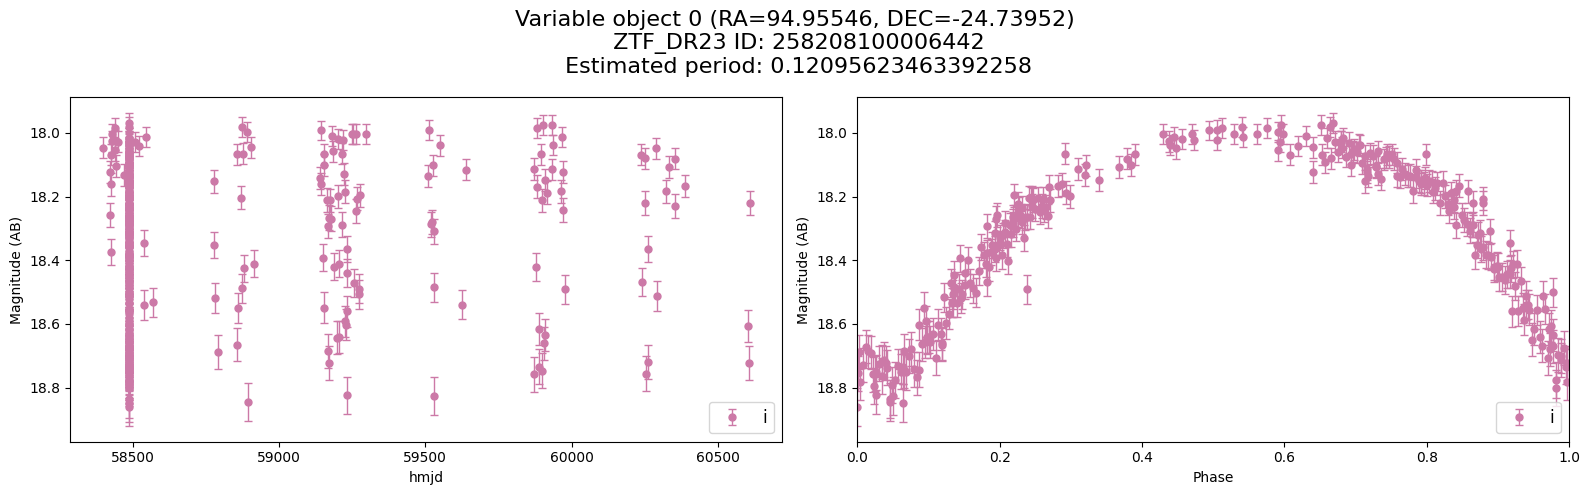

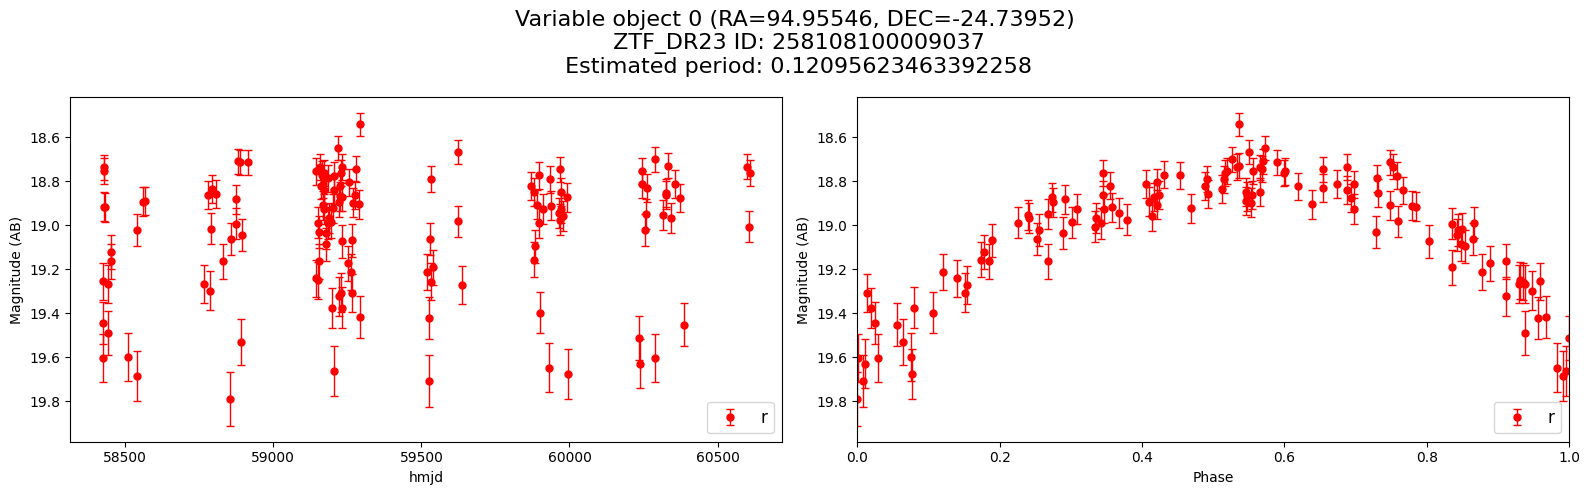

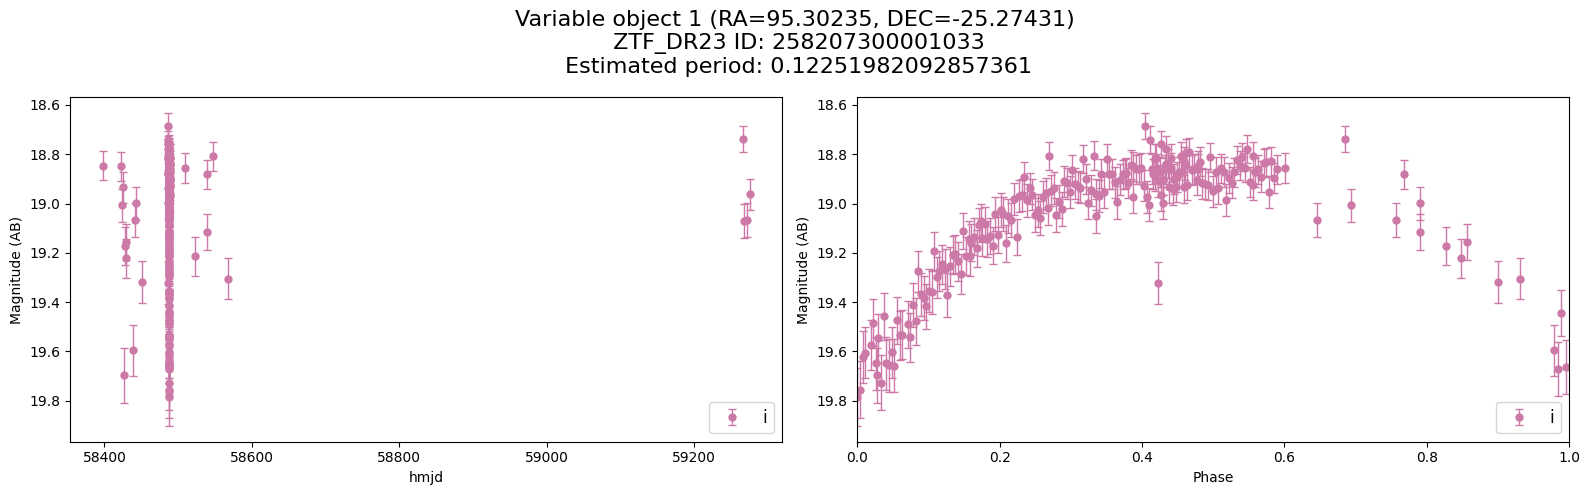

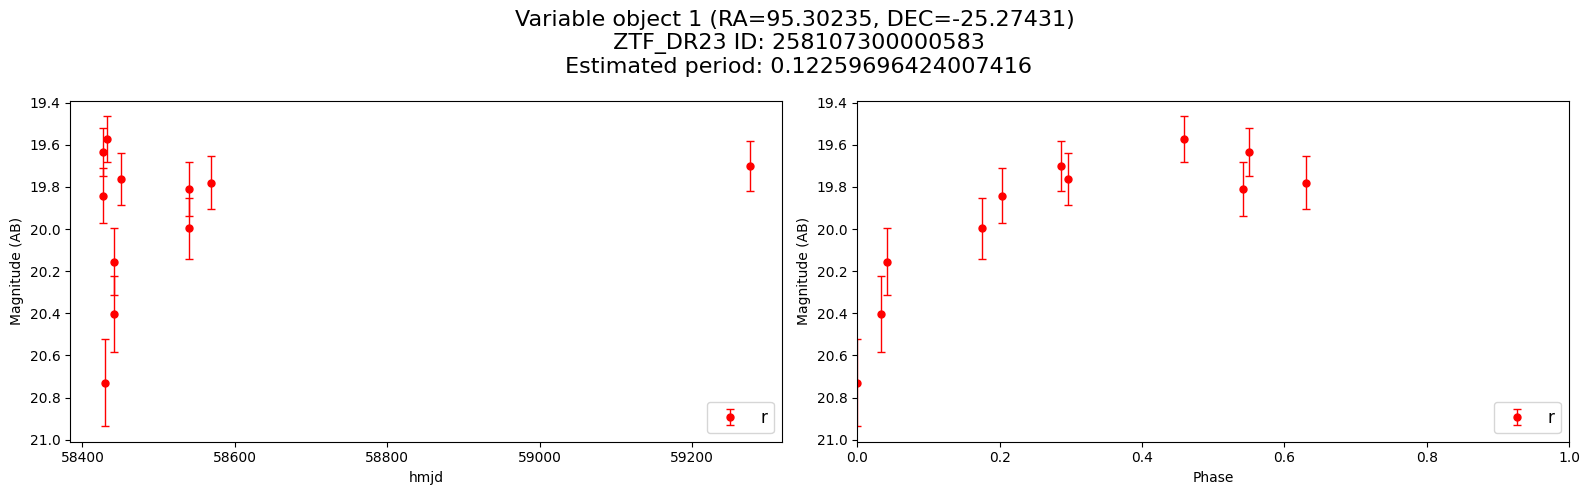

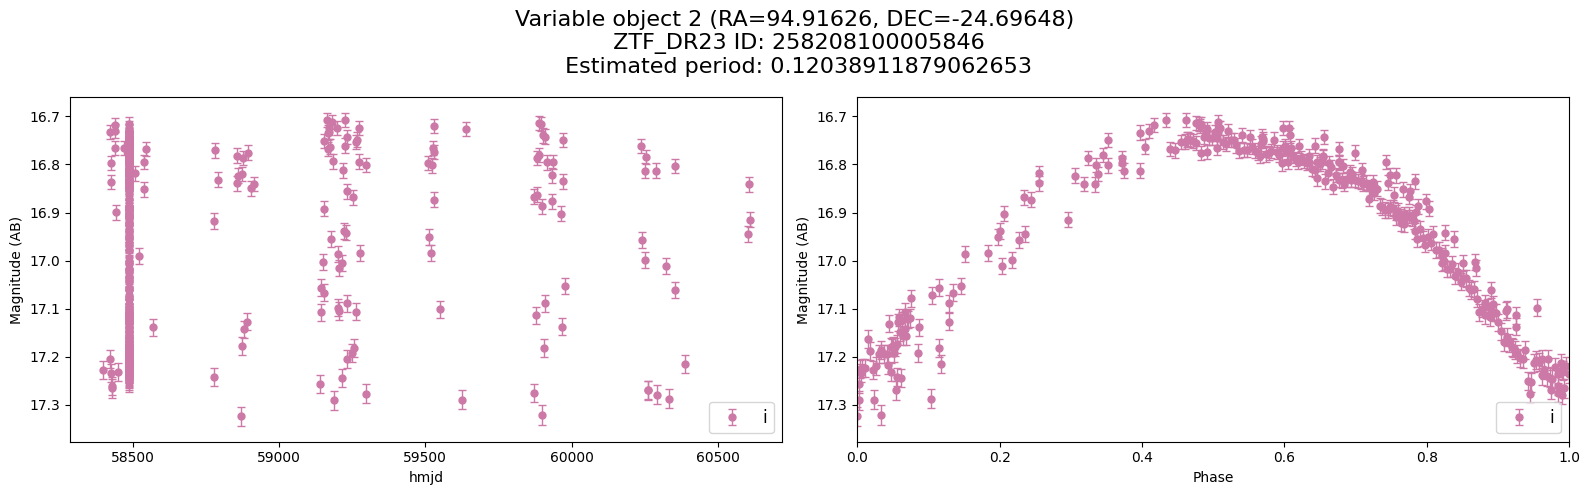

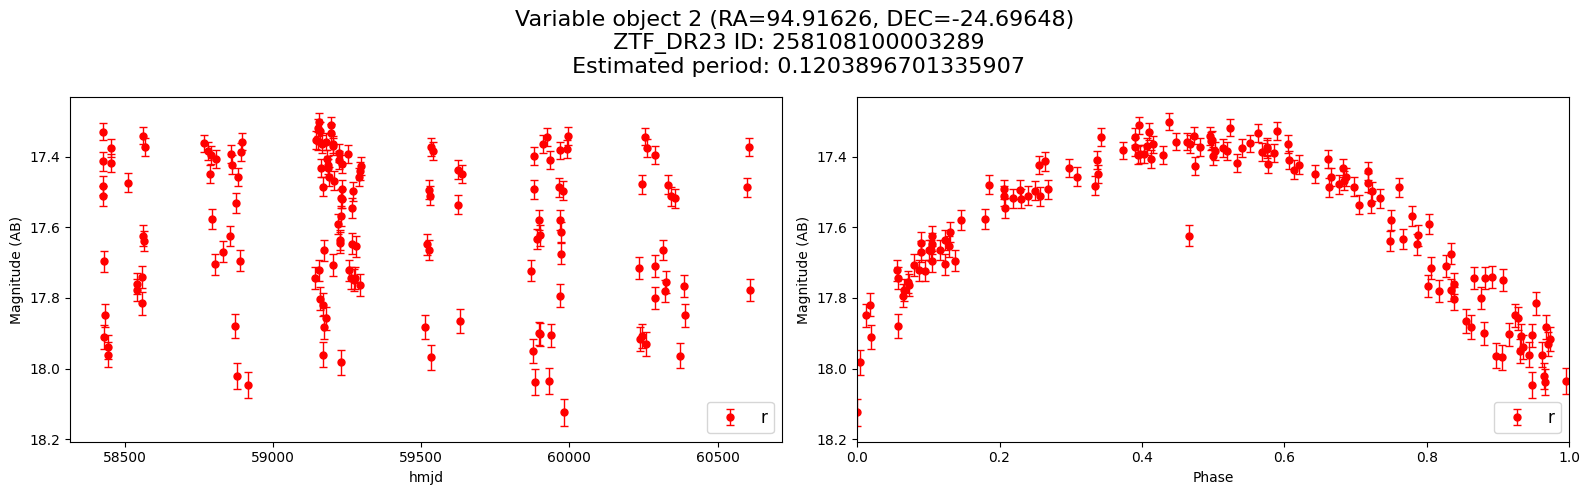

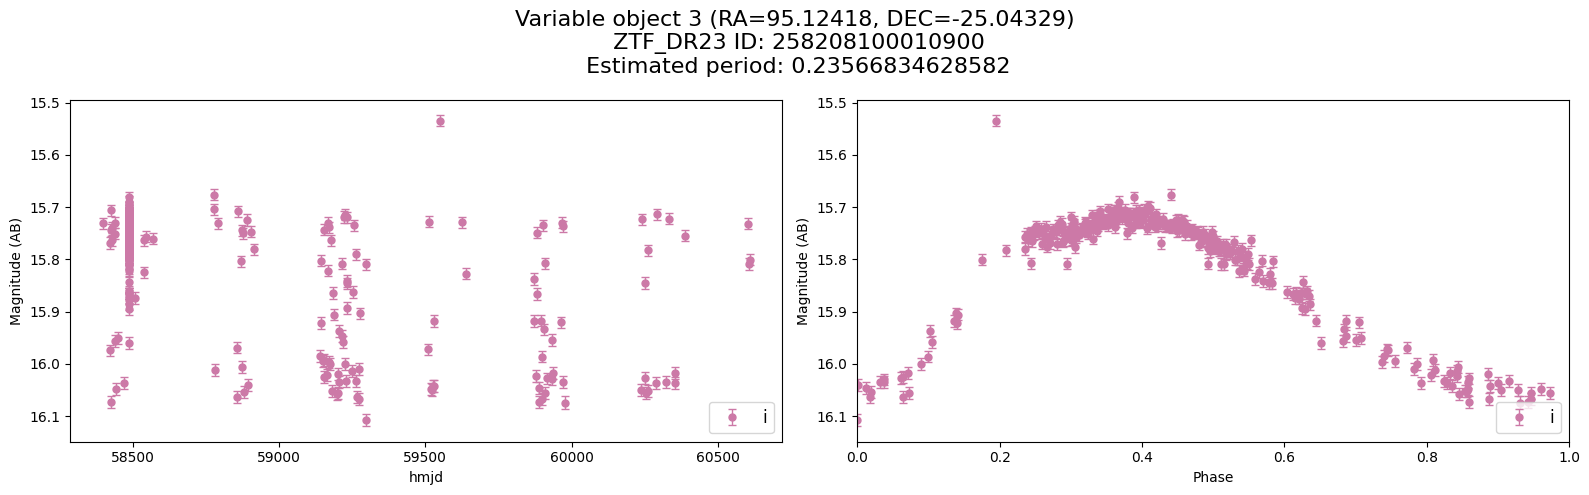

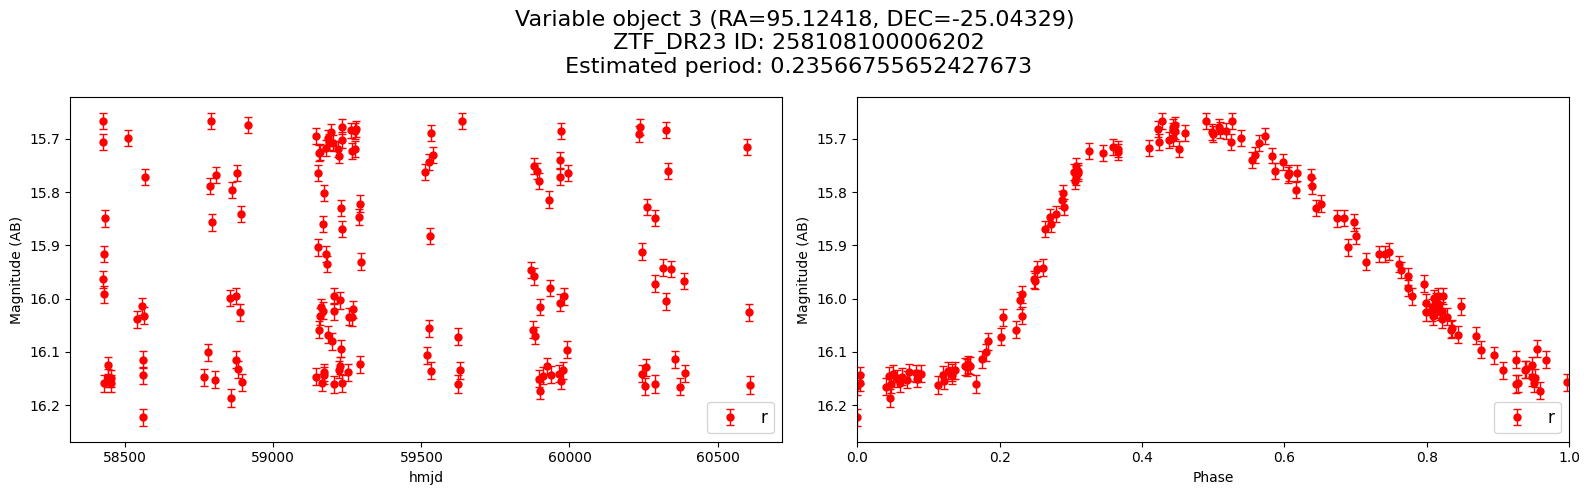

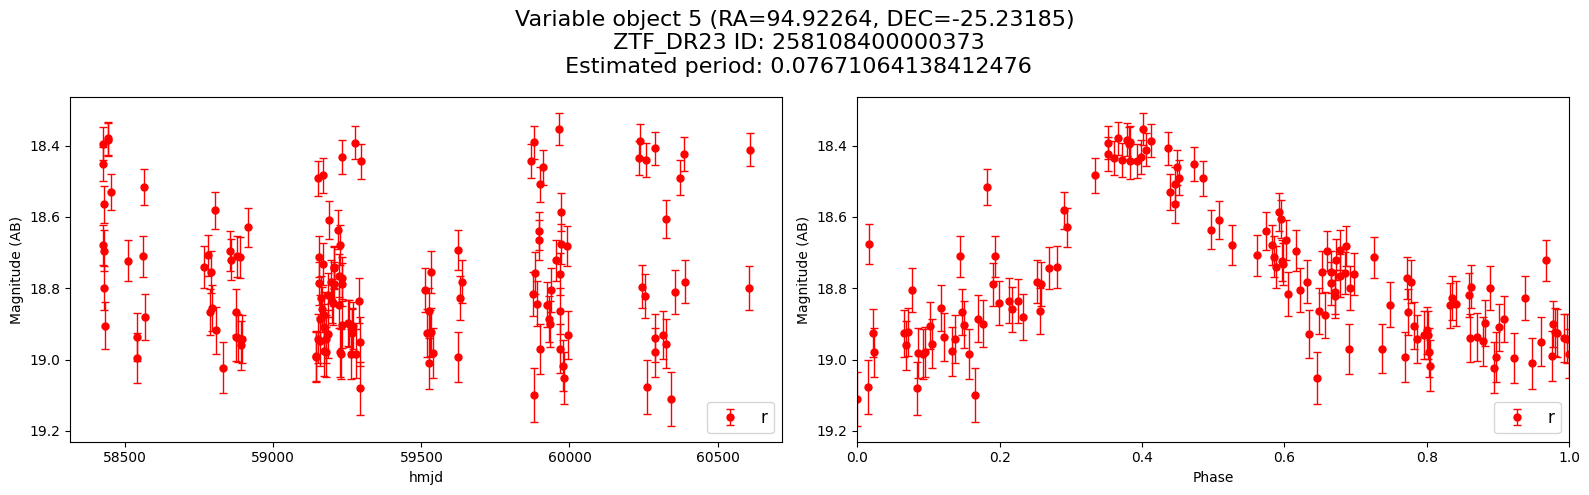

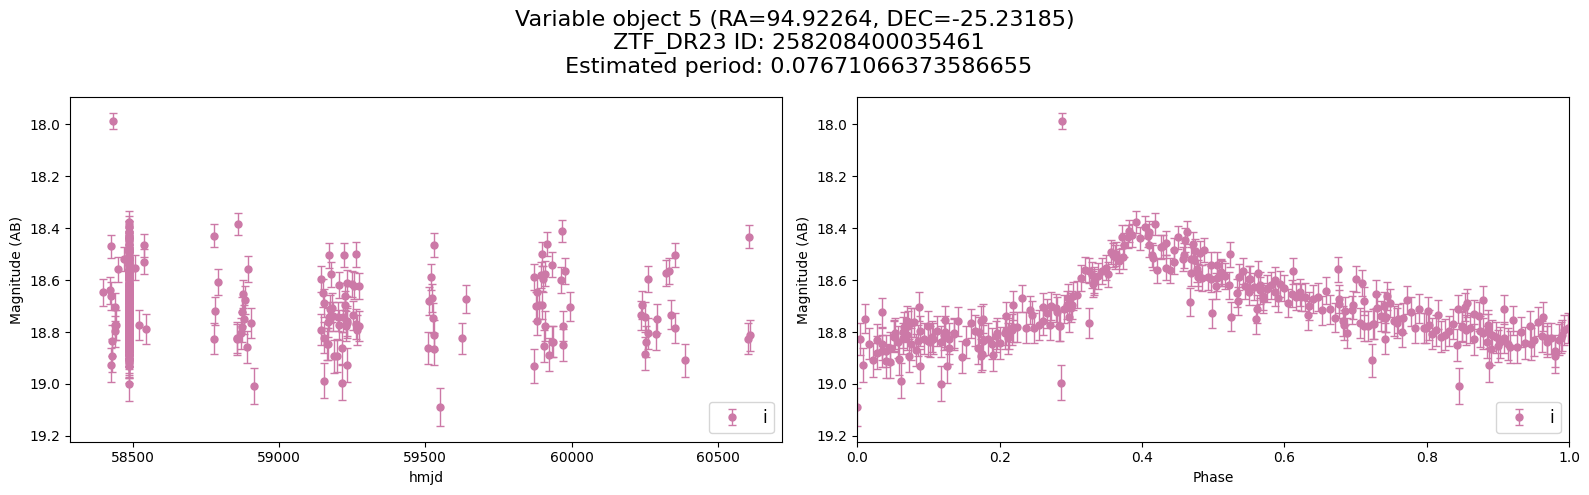

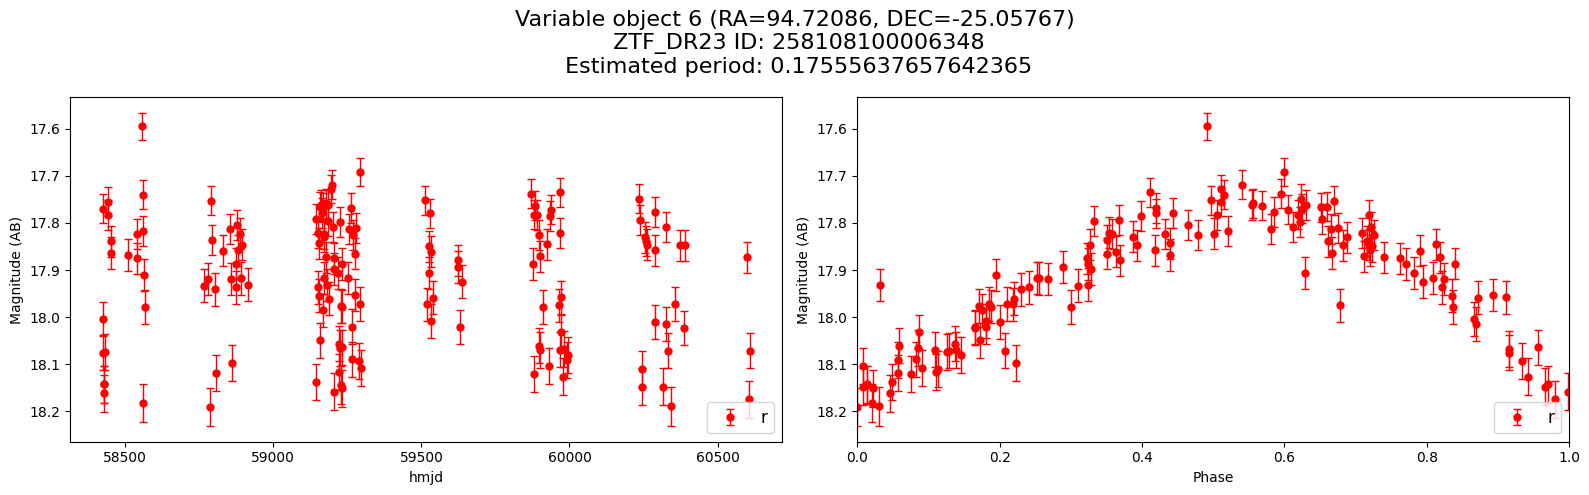

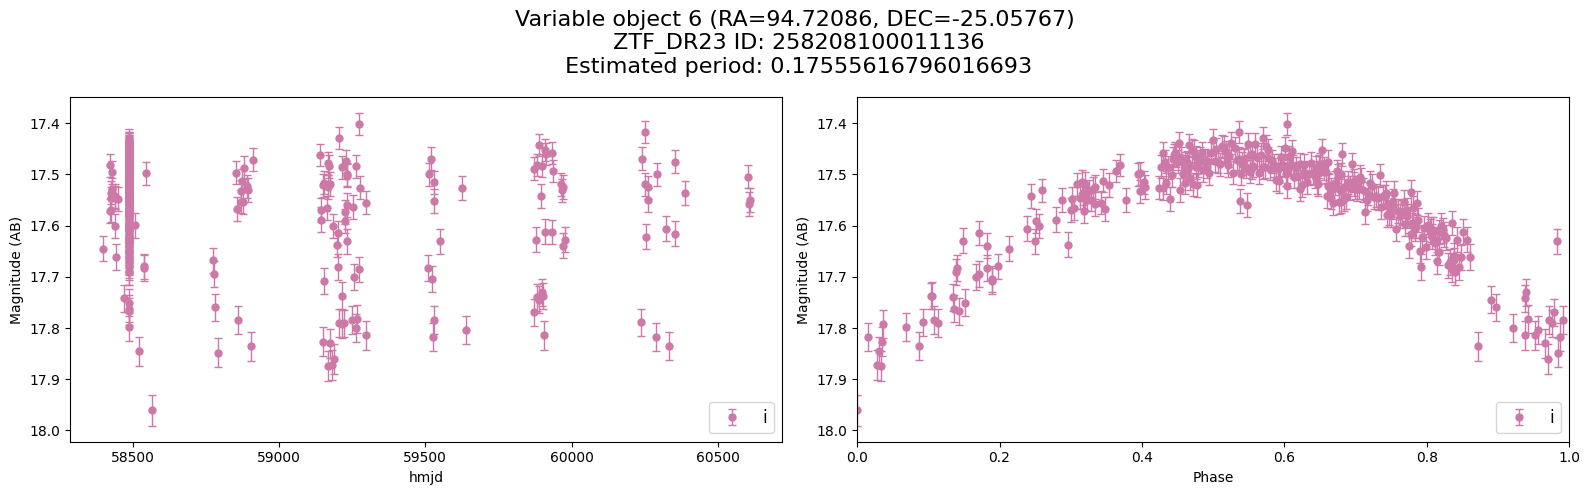

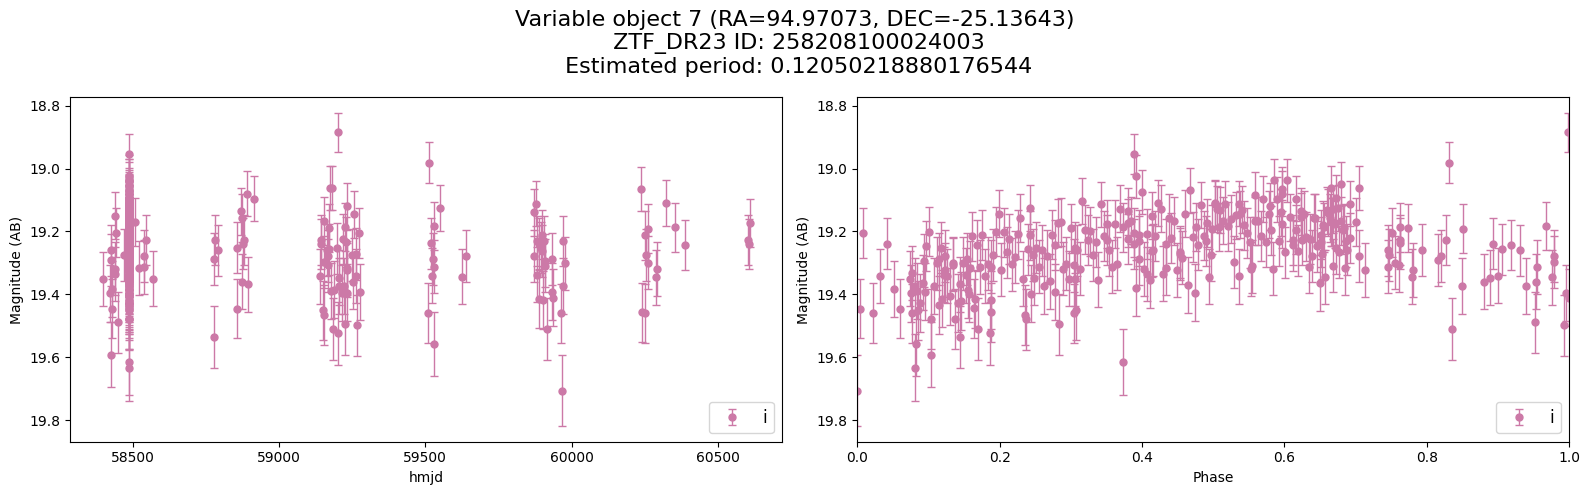

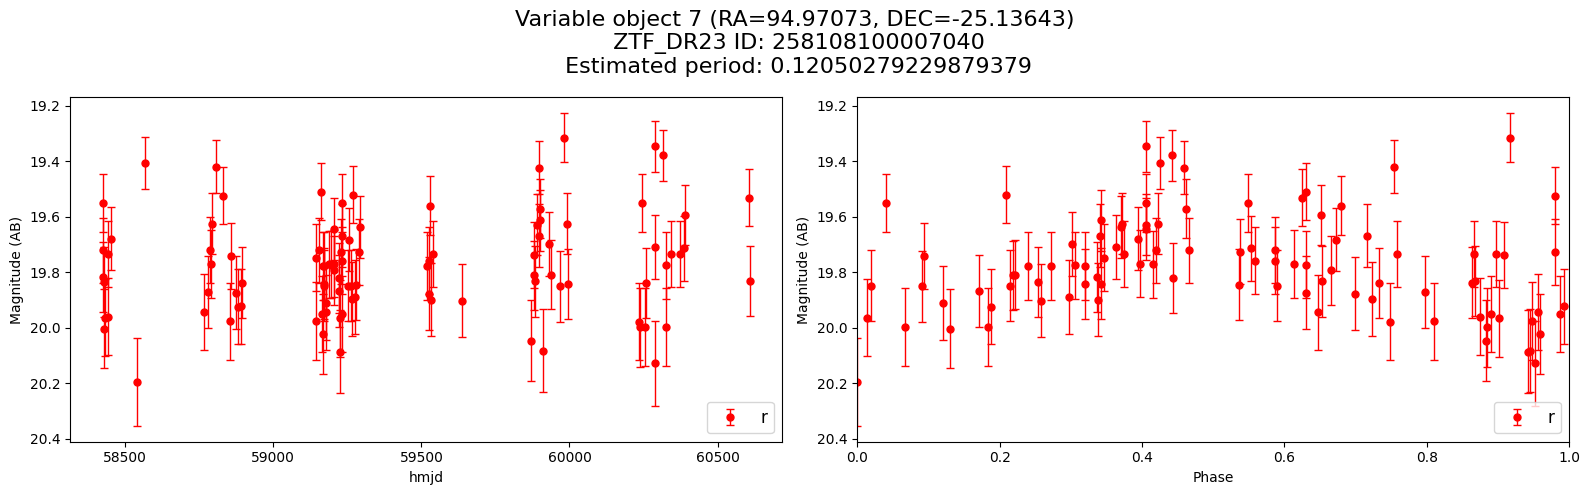

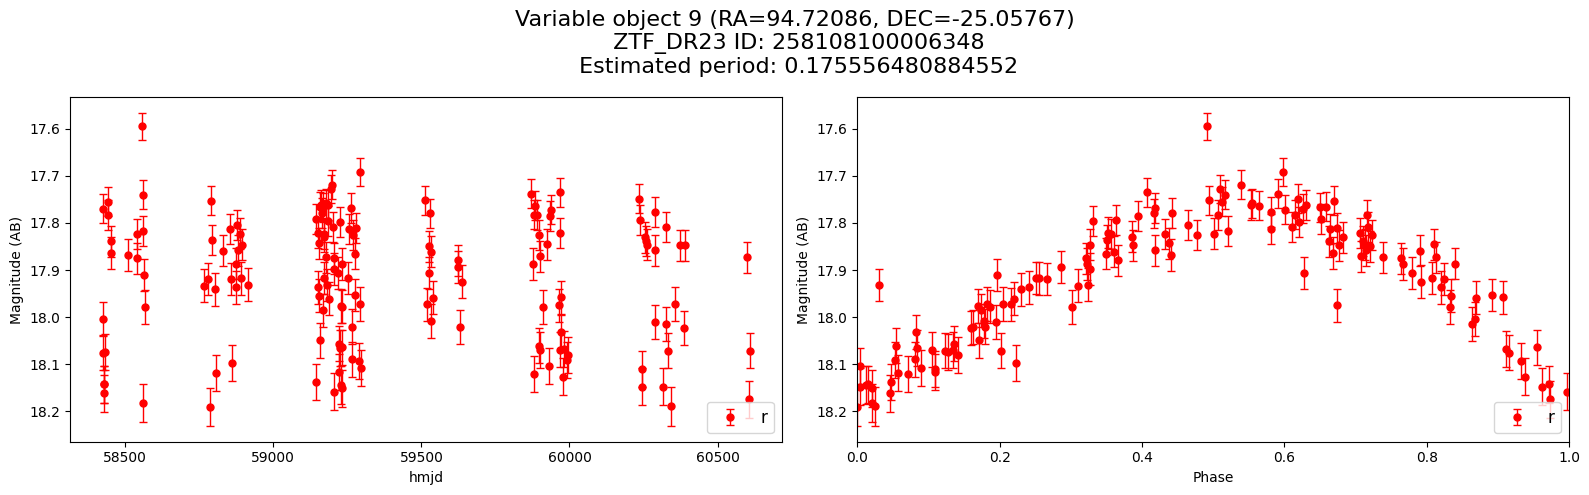

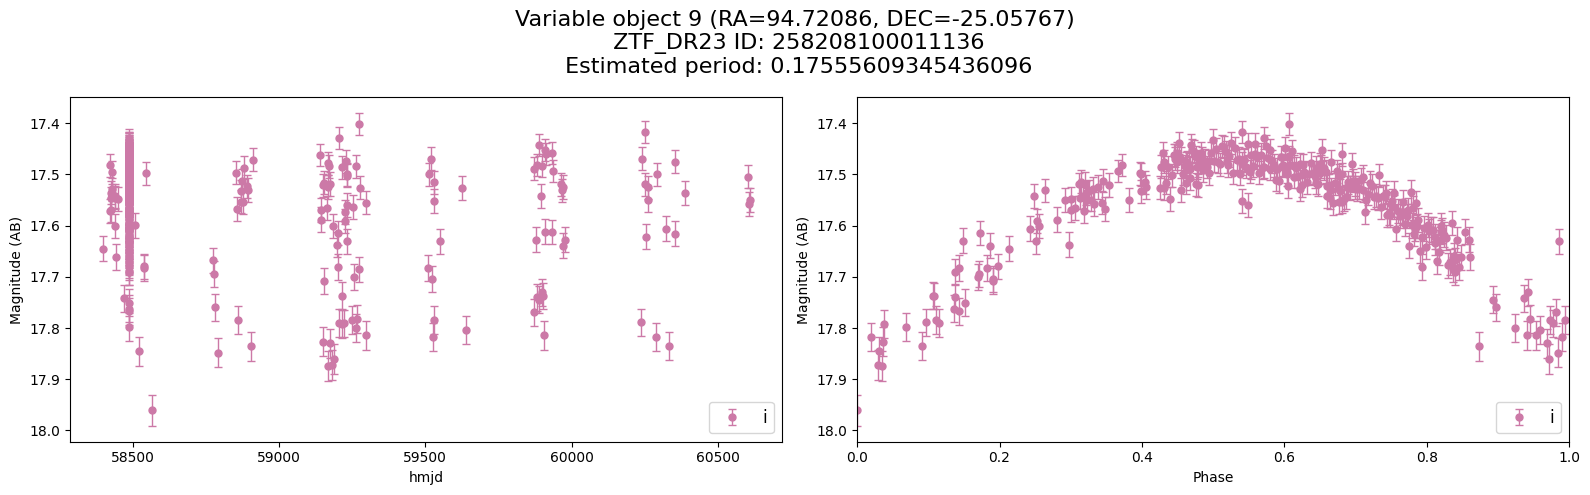

In [11]:
for _, row in result_df.iterrows():
    lc = row.lightcurve_ztf_dr23
    band = list(COLORS.keys())[row.filterid_ztf_dr23]
    
    # Calculating best period based on the initial estimate
    period = estimate_period(row.period_var, lc.hmjd, lc.mag)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    title = f"Variable object {row.index_var} (RA={row.ra_var}, DEC={row.dec_var})"
    title += f"\n ZTF_DR23 ID: {row["objectid_ztf_dr23"]}"
    title += f"\n Estimated period: {period}"
    fig.suptitle(title, fontsize=16)
    
    plot_mag_lightcurves(ax, lc, band, period)
    plt.tight_layout()
    plt.show()